# Zoidberg 2.0

We were given a dataset of x-rays, which took around 20 minutes to install from their server. To speed things up and for convenience we sanitized the dataset and uploaded it to hugging face hub. We will see how fast and concise this solution turned out to be.

Our goal with the dataset is to find the right machine learning model to help doctors in detecting pneumonia. We will proceed by pulling the `train` split of the dataset (as you can see with the `split="train"` parameter).


In [1]:
from datasets import load_dataset

dataset = load_dataset("Az-r-ow/chest_xray", split="train")

In [2]:
from PIL import Image
from io import BytesIO

labels = dataset.features["label"].names


def format_dataset(dataset):
    pd_dataset = dataset.to_pandas()
    pd_dataset["true_label"] = pd_dataset["label"].map(lambda x: labels[x])
    pd_dataset["image"] = pd_dataset["image"].map(
        lambda i: Image.open(BytesIO(i["bytes"]))
    )
    return pd_dataset


# Converting to pandas will encode the images to bytestrings
train_data = format_dataset(dataset)
train_data.head()

image  label true_label
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0     NORMAL
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0     NORMAL
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0     NORMAL
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0     NORMAL
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0     NORMAL

Now that we have our data ready, we can start by checking the number of image per `class`.


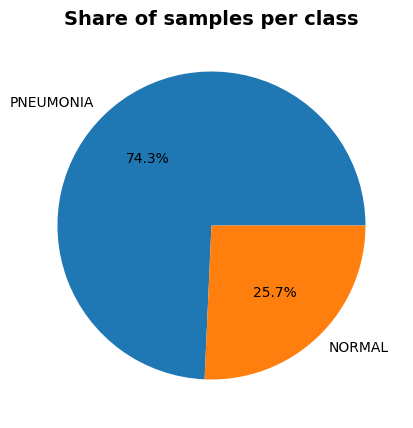

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt

def plot_value_counts(df, col_name, plot_title=""):
  """
  Plot the value counts of a column in a DataFrame.

  Parameters:
  -----------
  df : pandas DataFrame
      The DataFrame containing the column to plot.

  col_name : str
      The name of the column in the DataFrame for which to plot the value counts.

  plot_title : str, optional
      Title of the plot. Default is an empty string.

  Returns:
  --------
  None
  """
  class_counts = df[col_name].value_counts()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
  ax.set_title(plot_title, fontsize=14, fontweight="bold")

plot_value_counts(train_data, 'true_label', "Share of samples per class")

We can clearly see an imbalance between the two classes and that's something to keep in mind as it might lead any model towards over-fitting in favor of `infected` (for instances with label `1`).


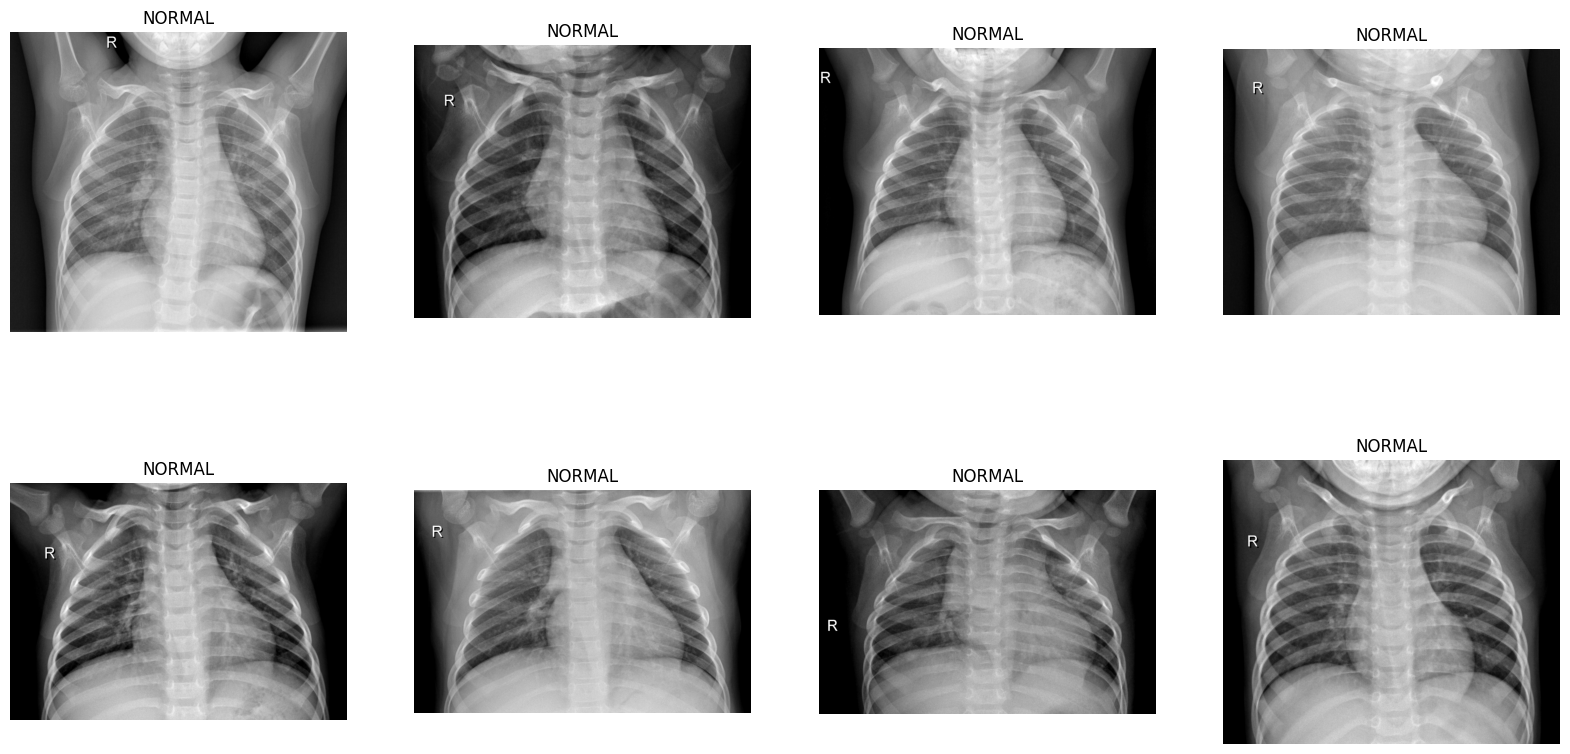

In [4]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd


def get_center_crop_coord(image, target_size=(100, 100)):
    """
    Calculates the coordinates for center cropping an image to the specified target size.

    Parameters:
        image (PIL.Image.Image): The input image to be center cropped.
        target_size (tuple): A tuple specifying the target size (width, height) for the cropped region.

    Returns:
        tuple: A tuple containing the coordinates (x, y, width, height) for center cropping the image.
    """
    width, height = image.size
    crop_x = (width - target_size[0]) // 2
    crop_y = (height - target_size[1]) // 2
    return (crop_x, crop_y, crop_x + target_size[0], crop_y + target_size[1])


# Displaying the images
def display_images(
    data, rows, columns, crop_area=None, scatter_coordinates=([], []), title=""
):
    if len(data) < (rows * columns):
        raise ValueError(
            f"Length data should be > than (rows * columns) we got : {rows * columns} and data length = {len(data)}"
        )

    x_scatter, y_scatter = scatter_coordinates
    is_dataframe = isinstance(data, pd.DataFrame)

    if rows <= 0 or columns <= 0:
        raise ValueError(
            f"Rows and columns can't be <= 0, got : rows = {rows} and columns = {columns}"
        )
    elif rows == 1 and columns == 1:
        fig, ax = plt.subplots()
        image = data[0] if not is_dataframe else data["image"][0]
        title = "" if not is_dataframe else data["true_label"][0]
        ax.imshow(image, cmap="gray")
        ax.set_title(title)
        plt.show()
        return

    fig, axes = plt.subplots(rows, columns, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        image = data[i] if not is_dataframe else data["image"][i]
        label = "" if not is_dataframe else data["true_label"][i]
        ax.imshow(image, cmap="gray")
        if i < len(x_scatter) and i < len(y_scatter):
            ax.scatter(x_scatter[i], y_scatter[i])
        ax.set_title(label)

        if crop_area:
            x, y, width, height = crop_area = get_center_crop_coord(image, crop_area)
            rect = patches.Rectangle(
                (x, y),
                crop_area[0],
                crop_area[1],
                linewidth=2,
                edgecolor="r",
                facecolor="none",
            )
            ax.add_patch(rect)

        ax.axis("off")

    plt.show()


display_images(train_data, 2, 4, title="something")

## Class Imbalance

### Problem

As we saw earlier in the pie chart, we have 3 times the number of x-rays of chests with `PNEUMONIA`. That will to a biased model with misleading accuracy. For example if we implement a model that only predicts `1` we will get 74.2% accuracy during training. But that goes AGAINST the goal of **generalization** that we want to achieve.

### Solutions

How can we proceed with this ?

- **Undersampling**
- **Oversampling**
- **Performance Metrics**

Let's go through some more details.

- **Undersampling** we will reduce the training set of $20\%$ which is not a lot considering that the difference between the two classes. This will result in the dataset consisting of $2712$ `PNEUMONIA` rows and $4053$ in total. Performing this operation will reduce the gap between the classes from $49\%$ to $39\%$. But not to worry, it will go down even more with **oversampling**.
- **Oversampling** we will increase the number of `NORMAL` samples by $20\%$ by randomly duplicating rows, the number being reasonable is enough to reduce the gap between the two classes yet not creating a lot of duplication which might corrupt the learning.
  By doing so we'll be able to reduce the gap to $25\%$.

- **Performance Metrics** when the time comes we'll use the metric that either minimizes false positives or false negatives based on the observations.


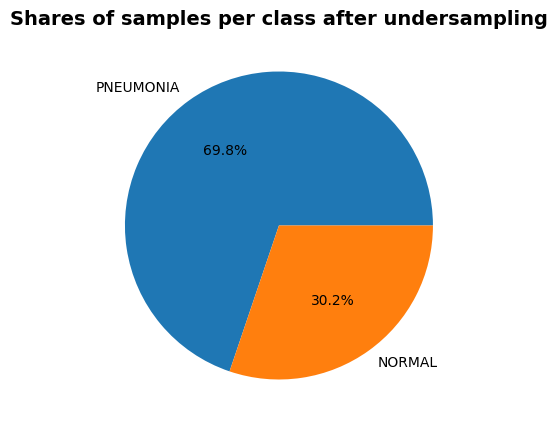

In [5]:
import pandas as pd


def undersample(df, true_label, frac):
    """
    Undersamples a DataFrame by reducing the number of samples for a specific class.

    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame containing the dataset to be undersampled.

    true_label : str
        The true label of the class for which to perform undersampling.

    rate : float or int
        The desired ratio of samples to retain for the specified class after undersampling.
        If float, it represents the fraction of samples to retain (0.0 to 1.0).
        If int, it represents the absolute number of samples to retain.

    Returns:
    --------
    pandas DataFrame
        The undersampled DataFrame with reduced number of samples for the specified class.

    Example:
    --------
    undersampled_df = undersample(df, 'class', 0.5)
    """
    undersampled_df = pd.concat(
        [
            df[df["true_label"] != true_label],
            df[df["true_label"] == true_label].sample(frac=frac),
        ]
    )
    return undersampled_df.reset_index(drop=True)


train_data = undersample(train_data, "PNEUMONIA", 0.8)  # Retaining 80% of the samples

plot_value_counts(
    train_data, "true_label", "Shares of samples per class after undersampling"
)

Things went as expected the gap between the two classes is not sitting at $39.6\%$ and will be going down even further with oversampling. We want to note that we purposely did not override the `train_data` variable to keep it as a backup in case our results are corrupted and we want to go back to the initial dataset.


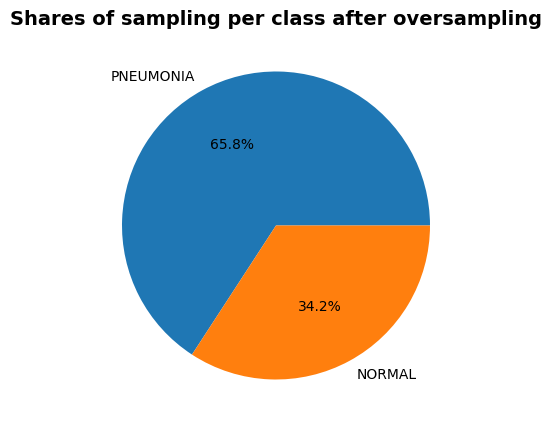

In [6]:
import math


def oversample(df, true_label, frac):
    """
    Oversamples a DataFrame by randomly duplicating the number of samples for a specific class.

    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame containing the dataset to be oversampled.

    true_label : str
        The true label of the class for which to perform oversampling.

    rate : float or int
        The desired ratio of samples to duplicated from the specified class.
        If float, it represents the fraction of samples to duplicate (0.0 to 1.0).
        If int, it represents duplicating the entirety of the samples.

    Returns:
    --------
    pandas DataFrame
        The oversampled DataFrame with the randomly duplicated number of samples for the specified class.

    Example:
    --------
    oversampled_df = oversample(df, 'class', 0.2)
    """
    majority_class = df[df["true_label"] != true_label]
    minority_class = df[df["true_label"] == true_label]
    frac = 1 + frac if frac < 1 else frac
    num_samples = math.ceil(len(minority_class) * frac)
    oversampled_minority = minority_class.sample(num_samples, replace=True)
    return pd.concat([majority_class, oversampled_minority]).reset_index(drop=True)


train_data = oversample(train_data, "NORMAL", 0.2)

plot_value_counts(
    train_data, "true_label", "Shares of sampling per class after oversampling"
)

Another win for the team, things are going as planned. The gap between the two classes has been reduced drastically and now with the right **performance metrics** we should be getting some good results.


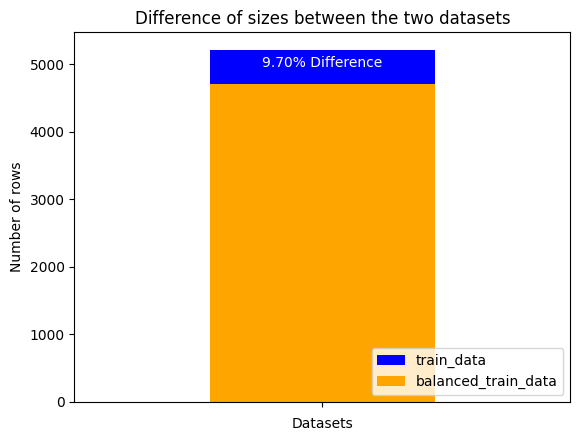

In [7]:
initial_data_num_rows = len(dataset)
balanced_train_data_num_rows = len(train_data)
avg = (initial_data_num_rows + balanced_train_data_num_rows) / 2
fig, ax = plt.subplots()

ax.bar(
    [""],
    [initial_data_num_rows, balanced_train_data_num_rows],
    width=0.4,
    label=["train_data", "balanced_train_data"],
    color=["blue", "orange"],
)
ax.bar([""], [0])
ax.text(
    0,
    avg,
    f"{((1 - (balanced_train_data_num_rows / initial_data_num_rows)) * 100):.2f}% Difference",
    ha="center",
    color="white",
)
ax.set_title("Difference of sizes between the two datasets")
ax.legend(loc="lower right")
plt.xlabel("Datasets")
plt.ylabel("Number of rows")
plt.show()

We were able to reduce the gap between the two classes from $49\%$ to $30\%$ by only decreasing the total number of samples by less than $10\%$ which is great. Considering that we have large dataset, this slight decrease shouldn't have any negative effect.

Now that our data is ready, we will start the training process.


## Observation

Let's first take a look at the images of the two classes side by side. We will be looking for similarities from within the different classes. We'll take `4` images from each class and display them.


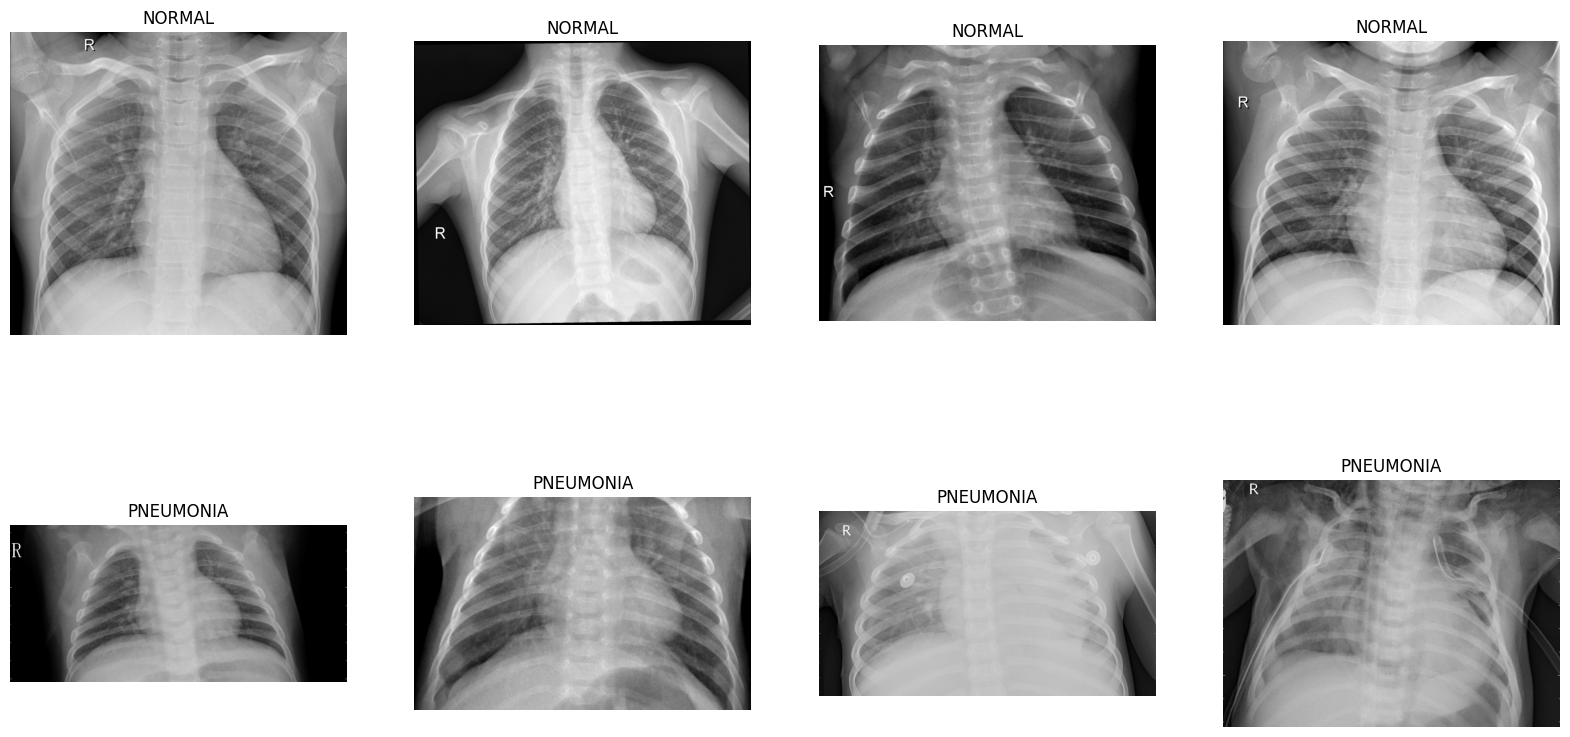

In [8]:
normal_images_sample = (
    train_data[train_data["true_label"] == "NORMAL"].head(4).reset_index(drop=True)
)
pneumonia_images_sample = (
    train_data[train_data["true_label"] == "PNEUMONIA"].head(4).reset_index(drop=True)
)
images_samples = pd.concat([normal_images_sample, pneumonia_images_sample]).reset_index(
    drop=True
)

display_images(images_samples, 2, 4)

## Data Processing

In some cases we can see a pattern between the images in each class. It seems like the x-rays with pneumonia have a larger density of white matter in the lungs which is in most cases located in the middle of the images. But it's not always very clear. However, one thing is sure : to reduce the noise in our dataset we should center crop the images in order to have the principal area of interest. Here's the following steps that we'll go over :

1. Center crop the images to remove the outside noise and regularize the images
2. Make sure the images are centered before moving on to `PCA`
3. Apply `PCA` (Principal Component Analysis) and plot the values of `PCA-1`, `PCA-2` and then `PCA-3`


In [9]:
import numpy as np


def preprocess_image(img, resize_size=(512, 512), target_size=(400, 400)):
    """
    Preprocesses an image by resizing and center cropping it to the target size. The image is also normalized.

    Parameters:
        img (PIL.Image.Image): The input image to be preprocessed.
        resize_size (tuple): A tuple specifying the resize size (width, height) for the preprocessed image.
        target_size (tuple): A tuple specifying the target size (width, height) for the preprocessed image.

    Returns:
        PIL.Image.Image: The preprocessed image resized to the `target_size`.

    Note:
    - The `target_size` should be < than the `resize_size`
    """
    if target_size > resize_size:
        raise ValueError(
            f"target_size can't be > than resize_size. Got target_size = {target_size} and resize_size = {resize_size}"
        )
    grayscale_image = img.convert("L")
    resized_image = grayscale_image.resize(resize_size)

    crop_coord = get_center_crop_coord(resized_image, target_size)

    cropped_image = resized_image.crop(crop_coord)
    return cropped_image

In [10]:
x_train = (
    train_data["image"]
    .map(lambda x: preprocess_image(x, (400, 400), (224, 224)))
    .reset_index(drop=True)
)

In [11]:
y_train = train_data["label"].reset_index(drop=True).to_numpy()
y_train

array([1, 1, 1, ..., 0, 0, 0])

In the previous code, we format the image and center crop them to narrow down to the essential parts of the scans which are the lungs. We'll demonstrate what the resulting images will look like after processing.


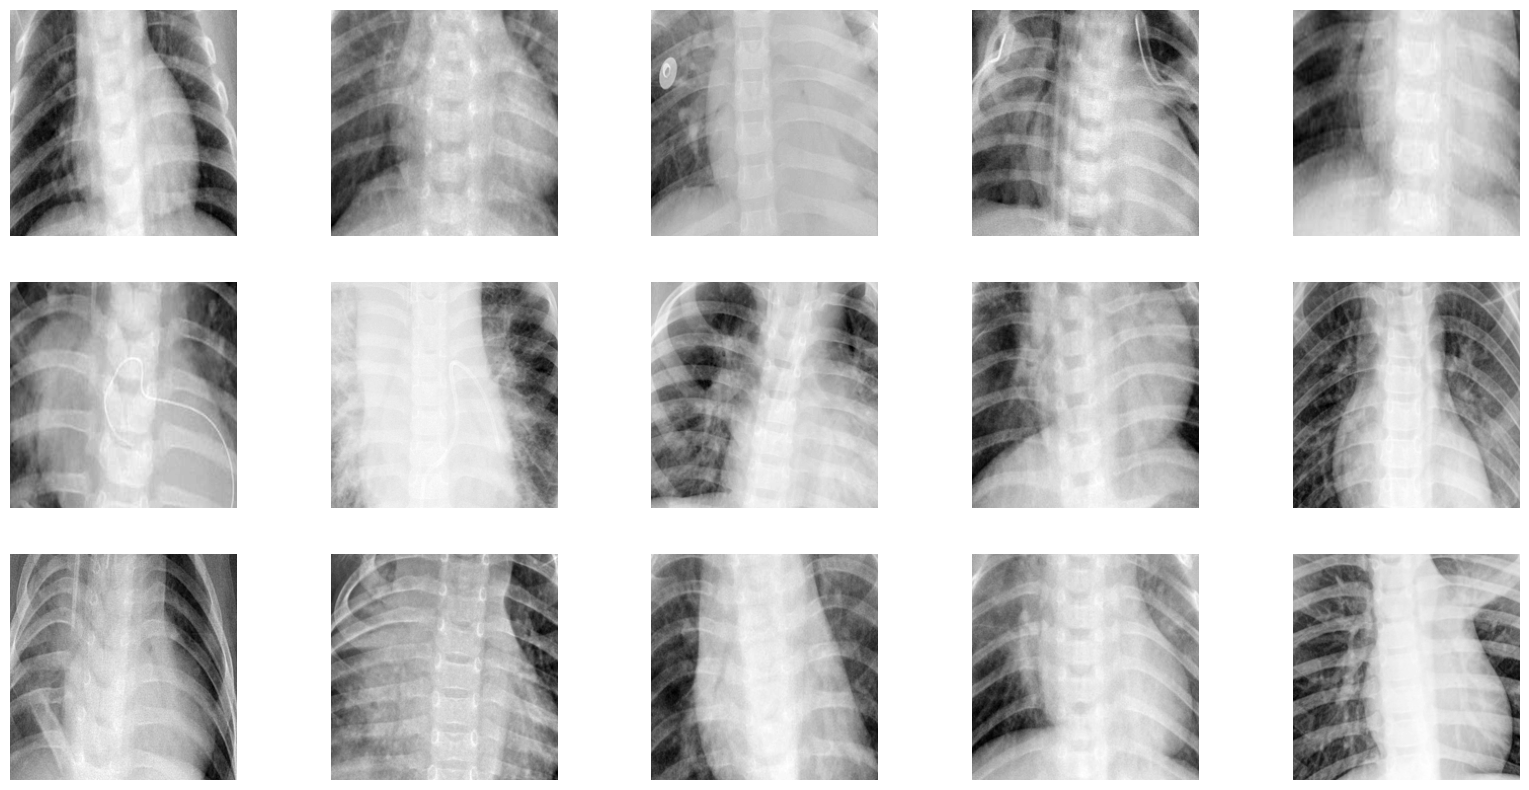

In [12]:
%matplotlib inline
display_images(x_train, 3, 5)

Then we will calculate the `center_of_mass` of each picture, this method basically averages the position of all the pixels of the image, weighted by their intensity values. The purpose of doing so, is to make sure the spine is somewhat centered in the cropped images.


mean offset :  16.68343949044586
std offset :  12.25172121258752


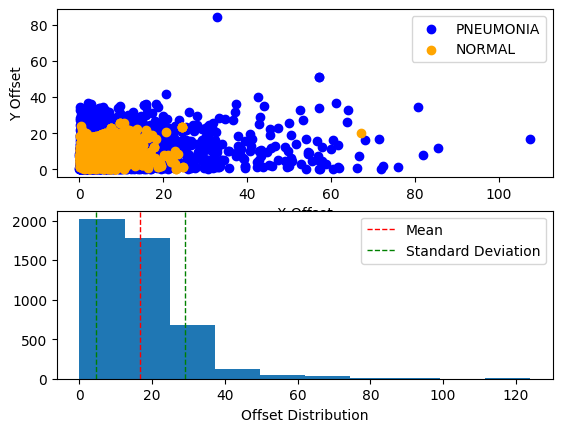

In [13]:
%matplotlib inline
from scipy.ndimage import center_of_mass


def get_center_of_mass(image):
    """
    Calculate the center of mass of a binary image.

    This function takes a binary image as input, where foreground pixels are represented as True (or 1)
    and background pixels are represented as False (or 0). It then computes the center of mass (COM)
    of the binary image, which represents the average position of all the foreground pixels.

    Parameters:
    - image: numpy.ndarray
        The input binary image represented as a NumPy array.

    Returns:
    - center: tuple
        A tuple containing the coordinates (row, column) of the center of mass of the binary image.
        The row and column indices start from 0.

    Note:
    - The input image should be a binary image where foreground pixels are represented by True (or 1) and
      background pixels are represented by False (or 0).
    - The center of mass is computed using the center_of_mass function from the scipy.ndimage module.
      Make sure to import this function before using get_center_of_mass.
    """
    binary_image = np.array(image) > 128
    return center_of_mass(binary_image)


def calculate_offset(image):
    """
    Calculate the offset between the center of mass (COM) and the geometric center of a binary image.

    Parameters:
    - image: numpy.ndarray
        The input binary image represented as a NumPy array.

    Returns:
    - offset: numpy.ndarray
        A NumPy array representing the offset between the center of mass and the geometric center.
        The offset is computed as the center of mass (COM) minus the geometric center.
        The offset has the same dimensionality as the input image.

    Note:
    - The geometric center is computed as the center of the image grid, which is assumed to be at the
      half width and half height of the image.
    - The offset indicates the displacement of the center of mass relative to the geometric center.
      A positive offset means the center of mass is shifted towards the bottom-right corner of the image,
      while a negative offset means it is shifted towards the top-left corner.
    """

    com = get_center_of_mass(image)

    image = np.array(image)

    geometric_center = np.array(image.shape) / 2

    offset = com - geometric_center

    return np.abs(offset)


offsets = [calculate_offset(img) for img in x_train]
x_offsets = np.array([offset[0] for offset in offsets])
y_offsets = np.array([offset[1] for offset in offsets])
# To not end up with fraction of pixels
offsets_distribution = np.round(x_offsets + y_offsets)
mean = np.mean(offsets_distribution)
std = np.std(offsets_distribution)

print("mean offset : ", mean)
print("std offset : ", std)

fig, axs = plt.subplots(2)

normal_indices = [i for i, c in enumerate(y_train) if labels[c] == "NORMAL"]
pneum_indices = [i for i, c in enumerate(y_train) if labels[c] == "PNEUMONIA"]

axs[0].scatter(
    x_offsets[pneum_indices], y_offsets[pneum_indices], c="blue", label="PNEUMONIA"
)
axs[0].scatter(
    x_offsets[normal_indices], y_offsets[normal_indices], c="orange", label="NORMAL"
)
axs[0].set_xlabel("X Offset")
axs[0].set_ylabel("Y Offset")
axs[0].legend()

axs[1].hist(offsets_distribution)
axs[1].axvline(mean, color="r", linestyle="dashed", linewidth=1, label="Mean")
axs[1].axvline(
    mean - std, color="g", linestyle="--", linewidth=1, label="Standard Deviation"
)
axs[1].axvline(mean + std, color="g", linestyle="--", linewidth=1)
axs[1].set_xlabel("Offset Distribution")
axs[1].legend()

plt.show()

We notice that the vast majority of the images are centered with an average offset of `4.7` pixels. However, very few images have some important offset. Does that mean that these images are not centered ? Let's see what it means...


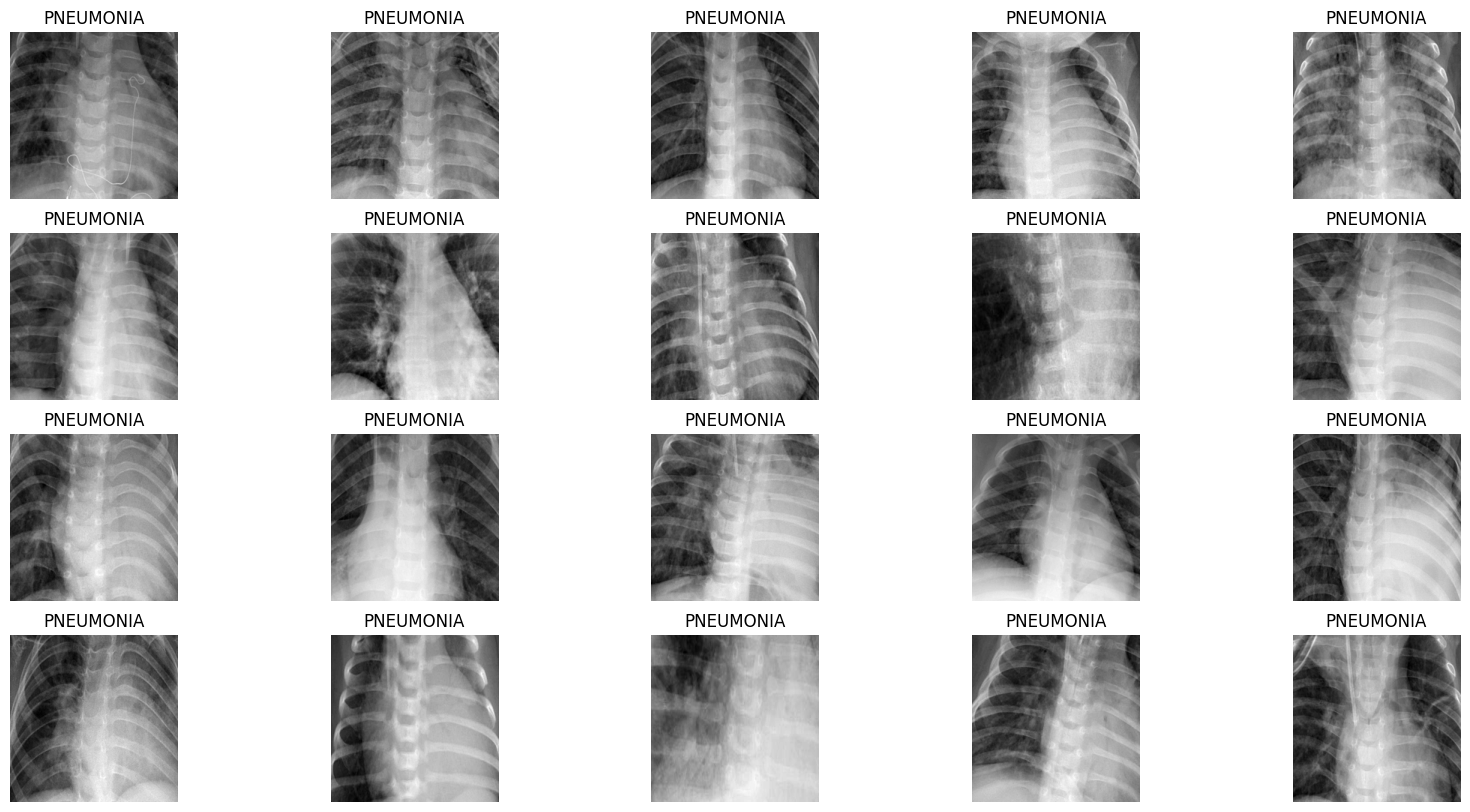

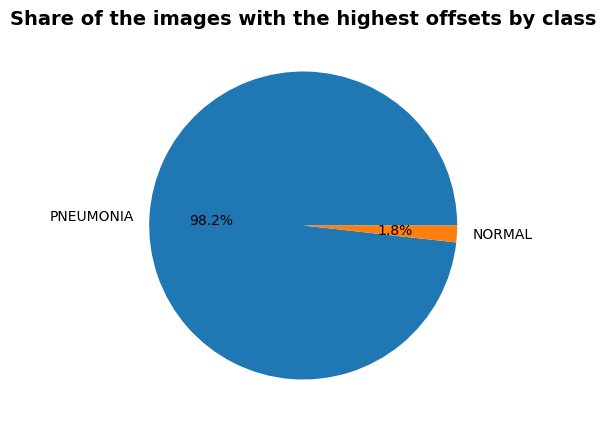

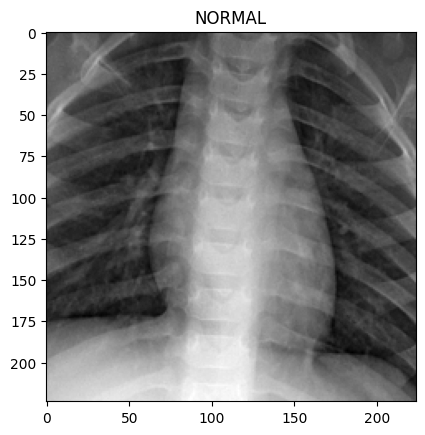

In [14]:
%matplotlib inline
high_offset_images = {"image": [], "true_label": [], "x_com": [], "y_com": []}

for i, offset in enumerate(offsets):
    if np.sum(offset) > 60:
        high_offset_images["image"].append(x_train[i])
        high_offset_images["true_label"].append(labels[y_train[i]])
        x_com, y_com = get_center_of_mass(x_train[i])
        high_offset_images["x_com"].append([x_com])
        high_offset_images["y_com"].append([y_com])

high_offset_images = pd.DataFrame(high_offset_images)
x_com = high_offset_images["x_com"].to_list()
y_com = high_offset_images["y_com"].to_list()

display_images(high_offset_images, 4, 5)

plot_value_counts(
    high_offset_images,
    "true_label",
    "Share of the images with the highest offsets by class",
)

# Filter normal images that have a high offset
normal_high_offset_images = high_offset_images[high_offset_images["true_label"] == "NORMAL"].reset_index(drop=True)
num_normal_images = len(normal_high_offset_images)

if num_normal_images:
    cols = num_normal_images if num_normal_images < 5 else 5
    rows = min(math.floor(num_normal_images / cols), 3)
    display_images(normal_high_offset_images, rows, cols)
    

In the previous code blocks, we extract the samples with the **highest** offset from the geometric center of image. We can conclude from the previous chart, that the images are well centered and the few exceptions we got are linked to a white blob located at a certain distance from the geometric center therefore pulling the `center_of_mass` towards it. Hence the exceptionally big `offsets`.

Now that we know that our images are well centered, we can proceed with finding the right model for **classification**.


In [15]:
from PIL import ImageDraw


def apply_black_border(image, border_width):
    """
    Apply a black border around the edges of the image.

    Parameters:
    - image: PIL.Image.Image
        The input image.
    - border_width: int
        The width of the black border to apply around the edges of the image.

    Returns:
    - bordered_image: PIL.Image.Image
        The image with a black border applied around the edges.
    """
    # Copy the original image
    bordered_image = image.copy()

    # Get the dimensions of the input image
    width, height = image.size

    # Create a black border mask
    mask = Image.new("L", (width, height), 0)
    draw = ImageDraw.Draw(mask)
    draw.rectangle((0, 0, width, border_width), fill=255)  # Top border
    draw.rectangle((0, height - border_width, width, height), fill=255)  # Bottom border
    draw.rectangle((0, 0, border_width, height), fill=255)  # Left border
    draw.rectangle((width - border_width, 0, width, height), fill=255)  # Right border

    # Paste the black border mask onto the image
    bordered_image.paste(0, (0, 0), mask)

    return bordered_image

## Dimension Reduction

We will first do a **Principal Component Analysis** (`PCA`) to reduce the dimensionality of the images, and then we will plot the first two `PCA`s and then the third in a 3-D plot.

> **NOTE:** This might take a few minutes depending on your hardware, but it's totally worth it


> **NOTE 2:** To cut on wait times set `n_components` to `0.8` it will keep $80\%$ of the dataset's information.


> **NOTE 3:** We will demonstrate why `0.8` [here](#comparing-classification-results-with-different-n_components)


In [16]:
from sklearn.decomposition import PCA


def normalize_images(images):
    return np.array([np.asarray(img).ravel() / 255.0 for img in images])


# normalizing the images into row vectors
x_train = normalize_images(x_train)

pca = PCA()

# To cut on wait time
# pca = PCA(n_components=0.8)

x_train_pca = pca.fit_transform(x_train)

Let's take a look at the **explained variance ratio** of each component for the first `10` components.


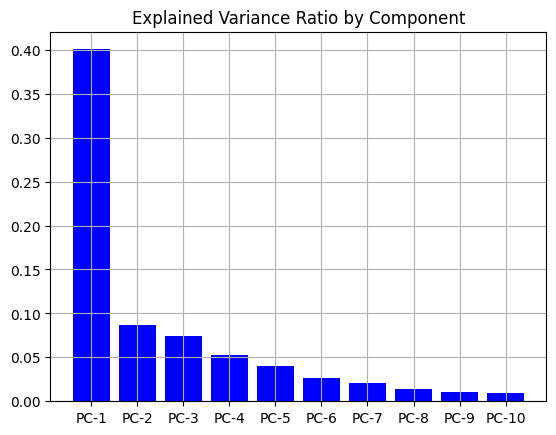

In [17]:
%matplotlib inline 

explained_variance_ratio_10 = pca.explained_variance_ratio_[:10]
pc_10 = [f"PC-{i}" for i in range(1, len(explained_variance_ratio_10) + 1)]

plt.bar(pc_10, explained_variance_ratio_10, color="blue")
plt.title("Explained Variance Ratio by Component")
plt.grid(True)
plt.show()

We can see that the first two **principal components** account for more than $40\%$ of the explained variance of the entire dataset. In other words, only **TWO** components account for more than $40\%$ of the dataset's information.


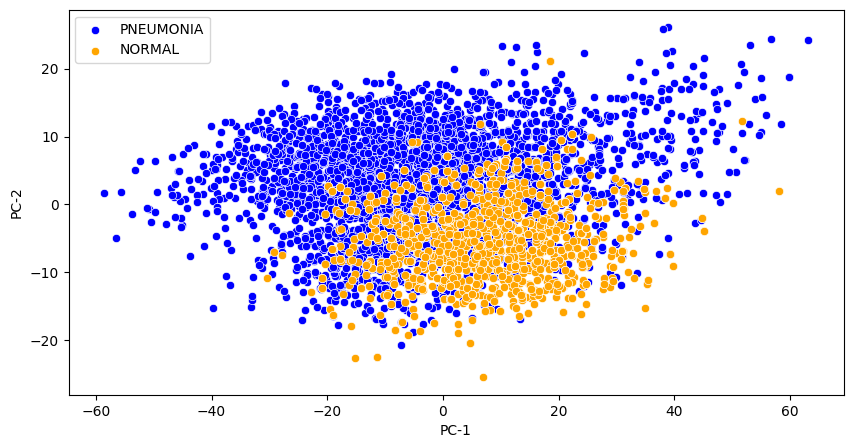

In [18]:
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(x=x_train_pca[pneum_indices, 0], y=x_train_pca[pneum_indices, 1], color="blue", label="PNEUMONIA")
sns.scatterplot(x=x_train_pca[normal_indices, 0], y=x_train_pca[normal_indices, 1], color="orange", label="NORMAL")
plt.xlabel("PC-1"), plt.ylabel("PC-2")
plt.show()

Observations from `PCA` on `PC-1` and `PC-2` :

- `NORMAL` data points tend to vary between -50 and 50 on `PC-1` and has mainly high values on `PC-2`
- `PNEUMONIA` data points in the other hand vary on a much wider range on both `PC-1` and `PC-2`
- Even though `NORMAL` instances seem to have more correlation between them, this can't be said for `PNEUMONIA` instances that are relatively more scattered along both axes.


Therefore, no definitive conclusion can be drawn from the previous plot. We will move on to plotting the first **three principal components** on a 3 dimensional space.


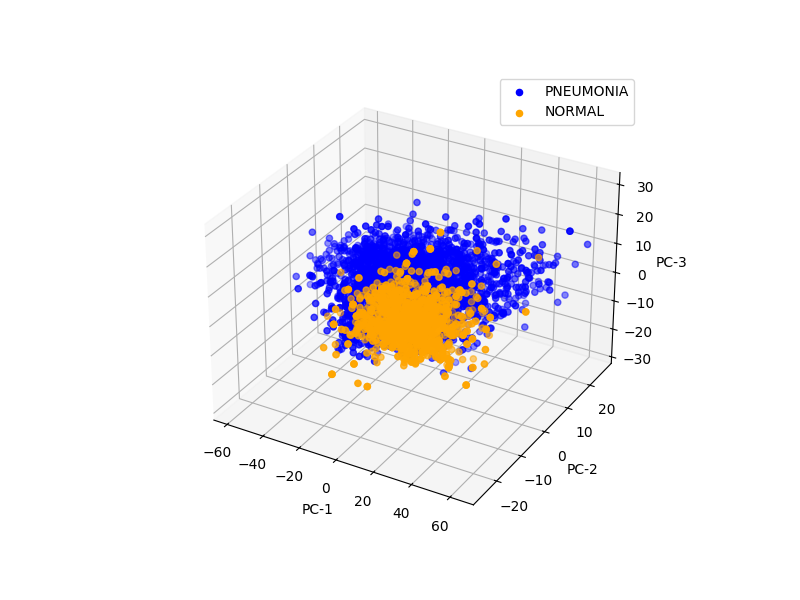

In [19]:
%matplotlib widget

# Assuming X_3d is your 3D data array and labels is your corresponding labels array
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    x_train_pca[pneum_indices, 0],
    x_train_pca[pneum_indices, 1],
    x_train_pca[pneum_indices, 2],
    color="blue",
    label="PNEUMONIA"
)

ax.scatter(
    x_train_pca[normal_indices, 0],
    x_train_pca[normal_indices, 1],
    x_train_pca[normal_indices, 2],
    color="orange",
    label="NORMAL"
)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')

plt.legend()
plt.show()

Even though a clear separation is not present, adding the third **principal component** did help us in getting extra underlying structure in the data.


Now before passing the reduce data to a model, let's see how many **components** account for `[.8, .9, .95, .99]` of the variance of the entire dataset. Visualizing it would help us make the decision of choosing the right number of components to proceed with without losing a lot of information.


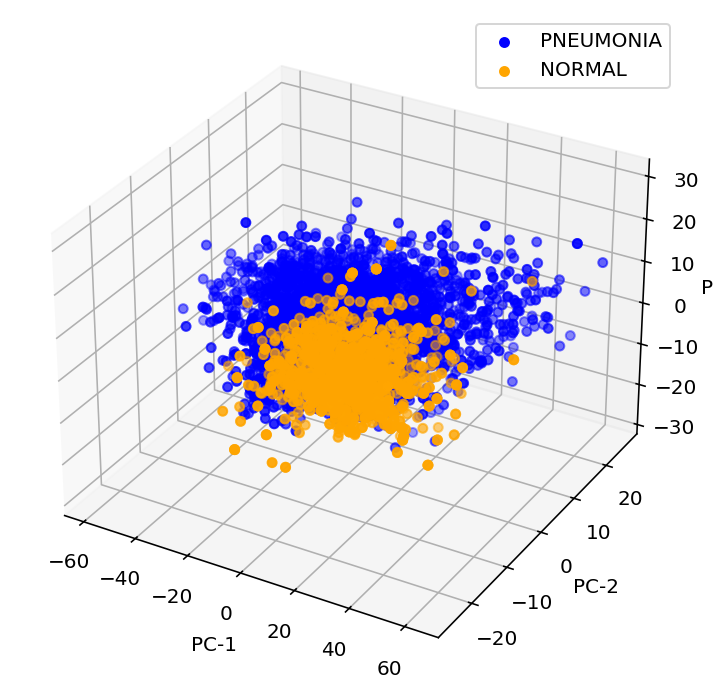

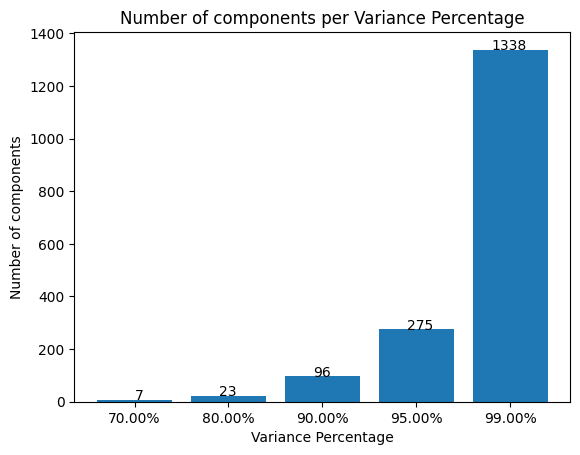

In [20]:
%matplotlib inline

def components_for_variance_percentage(variance_ratios, per=0.99):
    """
    Calculate the number of components required to achieve a given percentage of variance.

    Parameters:
    - variance_ratios (array-like): Array containing the explained variance ratios for each component.
    - per (float): Desired percentage of variance to be explained, in the range [0, 1].

    Returns:
    - int: Number of components needed to explain the specified percentage of variance.
    """
    cumulative_variance = np.cumsum(variance_ratios)
    return np.argmax(cumulative_variance >= per) + 1


percentages = [0.7, 0.8, 0.9, 0.95, 0.99]
num_components = [
    components_for_variance_percentage(pca.explained_variance_ratio_, per)
    for per in percentages
]

fig, ax = plt.subplots()
bars = ax.bar(["{:.2%}".format(value) for value in percentages], num_components)
for bar in bars:
    yval = bar.get_height()
    ax.text(
        (bar.get_x() + (bar.get_width() / 2) - (math.floor(len(str(yval)) / 2) / 10)),
        yval + 0.005,
        yval,
    )

ax.set_title("Number of components per Variance Percentage")
ax.set_xlabel("Variance Percentage")
ax.set_ylabel("Number of components")
plt.show()

Initially, we had images of size `(400,400)` that's $160000$ parameter per image. After dimension reduction, we're able to retain $99\%$ of the information with only $1724$ components. We will experiment using each of these number of components with a **Support Vector Machine** (`SVM`) to get a comparison on how much they affect the score.


We'll start by keeping only the number of components that represents $99\%$ by and dropping the rest.


In [22]:
per_to_ncomponents = {
    percentages[i]: num_components[i] for i in range(len(num_components))
}

x_train_pca = x_train_pca[:, : per_to_ncomponents[0.99]]

We will also need to apply dimension reduction to `x_test`.


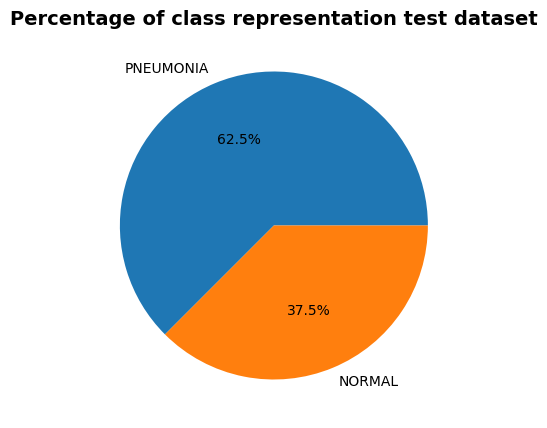

In [37]:
# Fetching the test data from hugging face
test_dataset = load_dataset("Az-r-ow/chest_xray", split="test")
test_dataset = format_dataset(test_dataset)

plot_value_counts(
    test_dataset, "true_label", "Percentage of class representation test dataset"
)

# Formatting the images
x_test = (
    test_dataset["image"]
    .map(lambda x: preprocess_image(x, (400, 400), (224, 224)))
    .reset_index(drop=True)
    .to_numpy()
)
# Transforming the images to vectors with values between [0, 1]
x_test = normalize_images(x_test)
y_test = test_dataset["label"].to_numpy()

# Reduce dimensions of the test data
x_test_pca = pca.transform(x_test)

### Comparing classification results with different n_components


Now that we have our training and testing set are ready, we can move on with **Support Vector Classification** which is an `SVM` for classification. We will use it with `kernel="rbf"` because it work best with complex decision boundaries between classes. Also, we will not tune any hyperparameters yet because our goal is to compare the scores between the data with the different `n_components`.


In [24]:
%matplotlib inline

from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix

scores = []
confusion_matrices = []

for percentage, n_components in per_to_ncomponents.items():
  svc = SVC(kernel="rbf")
  svc.fit(x_train_pca[:, :n_components], y_train)
  y_pred = svc.predict(x_test_pca[:, :n_components])
  cm = confusion_matrix(y_test, y_pred)
  confusion_matrices.append(cm)
  score = svc.score(x_test_pca[:, :n_components], y_test)
  scores.append(round(score, 3))

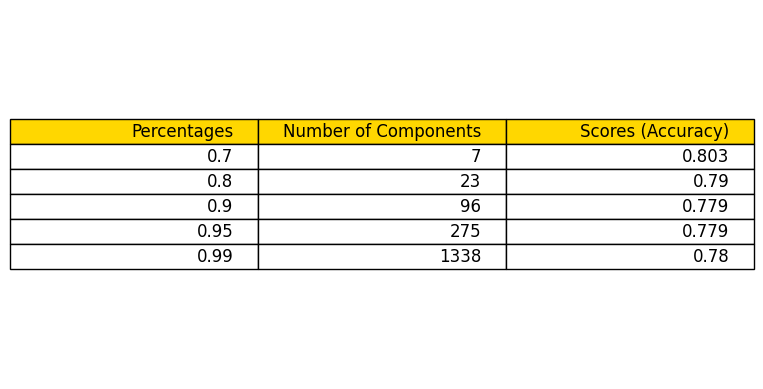

In [25]:
svc_scores_data = [
    [a, b, c]
    for a, b, c in zip(
        list(per_to_ncomponents.keys()), list(per_to_ncomponents.values()), scores
    )
]
svc_scores_data.insert(0, ["Percentages", "Number of Components", "Scores (Accuracy)"])

fig, ax = plt.subplots()
table = ax.table(cellText=svc_scores_data, loc="center")
table.set_fontsize(12)
table.scale(1.5, 1.5)

for i in range(len(svc_scores_data[0])):
    table[(0, i)].set_facecolor("#FFD700")
ax.axis("off")
plt.show()

Here's what the confusion matrix for each looks like :


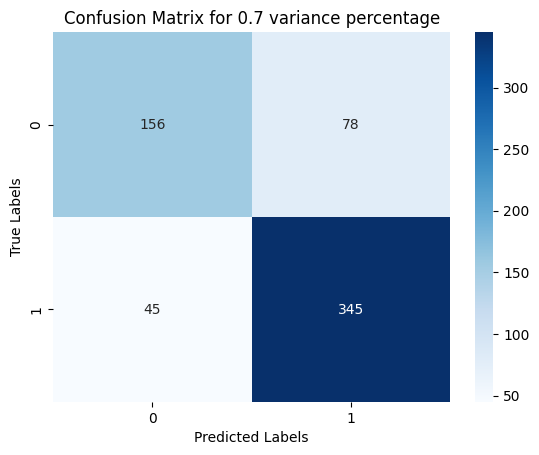

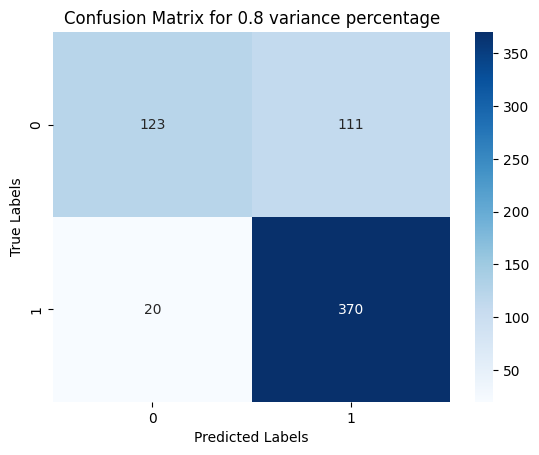

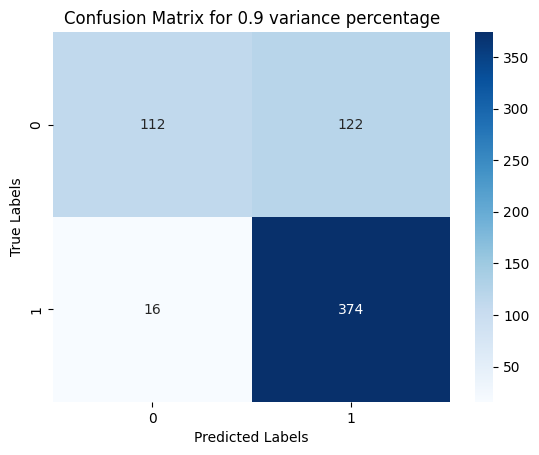

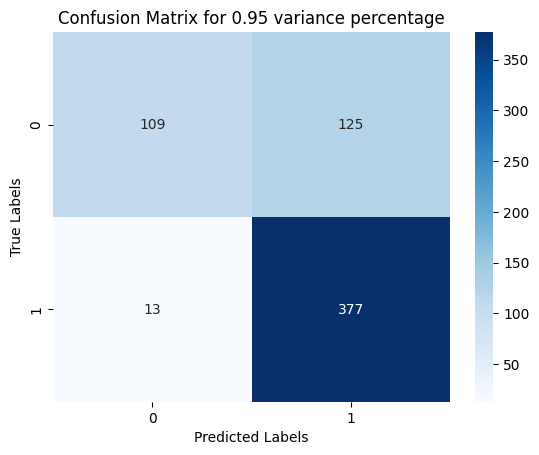

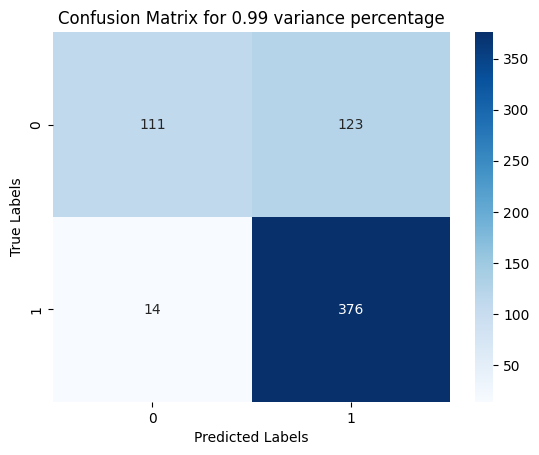

In [26]:
for i, cm in enumerate(confusion_matrices):
    plt.figure(i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(
        f"Confusion Matrix for {list(per_to_ncomponents.keys())[i]} variance percentage"
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

#### Conclusion on n_components

There is little to no difference in the accuracy scores between the different number of components. If anything, `n_components` representing $80\%$ of the dataset's variance is performing slightly better than the rest (which can be established through the confusion matrices). Therefore, we can move on by only using only the number of components that represent $80\%$ of the dataset's **variance**.


In [27]:
x_train_pca = x_train_pca[:, : per_to_ncomponents[0.8]]

## Model Discovery

We will use `RandomizedSearchCV` with the `f1` scoring to be able to test a wide array of hyperparameters the most efficient way possible. The reason why we use `f1` scoring is that we have class imbalance and accuracy only captures the correct guesses. So if we have a **dummy** model that only guesses the majority class, we will have a score of $\approx63\%$ pretty _decent_ right ? So instead, `f1` calculates the **harmonic mean** of **recall** ($\frac{TruePositives}{TruePositives + FalseNegatives}$) and **precision** ($\frac{TruePositives}{TruePositives + FalsePositives}$).


In addition, for each model, after extracting the best parameters we will `train` and `evaluate` them with the found parameters using **Cross Validation** (with `StratifiedKFold` to preserve percentage of samples of each class) whilst keeping track of `["f1", "accuracy", "roc_auc"]` scores for maximum generalization.


Starting with `SVC` (since it was used earlier), we will test the model with different `C`s and `kernels=['rbf', 'poly']`s.


In [40]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svc = SVC()

param_distributions = {
    "C": [0.1, 1, 10, 100, 1000],
    "kernel": ["rbf", "poly", "sigmoid"],
    "degree": list(range(1, 11)),  # Just for "poly"
}

clf = RandomizedSearchCV(svc, param_distributions, scoring="f1", cv=cv, random_state=42)
scv_search = clf.fit(x_train_pca, y_train)
scv_search.best_params_

{'kernel': 'rbf', 'degree': 7, 'C': 10}

In [41]:
import re


def plot_cv_results(cv_results_, title=""):
    df = pd.DataFrame(cv_results_)
    df = df.sort_values(by="rank_test_score")

    pattern = re.compile(r"split[0-9]+_test_score")

    split_columns = [c for c in df.columns.values.tolist() if pattern.match(c)]

    # Picking only the columns to plot
    df = df[["params"] + split_columns]
    df["params"] = df["params"].astype(str)

    # Rotating the dataframe
    df = df.melt(id_vars="params", value_vars=split_columns)

    plt.figure(figsize=(10, 6))
    sns.boxplot(df, x="value", y="params", fliersize=0)
    plt.xlabel("F1 Score")
    plt.title(title)
    plt.show()

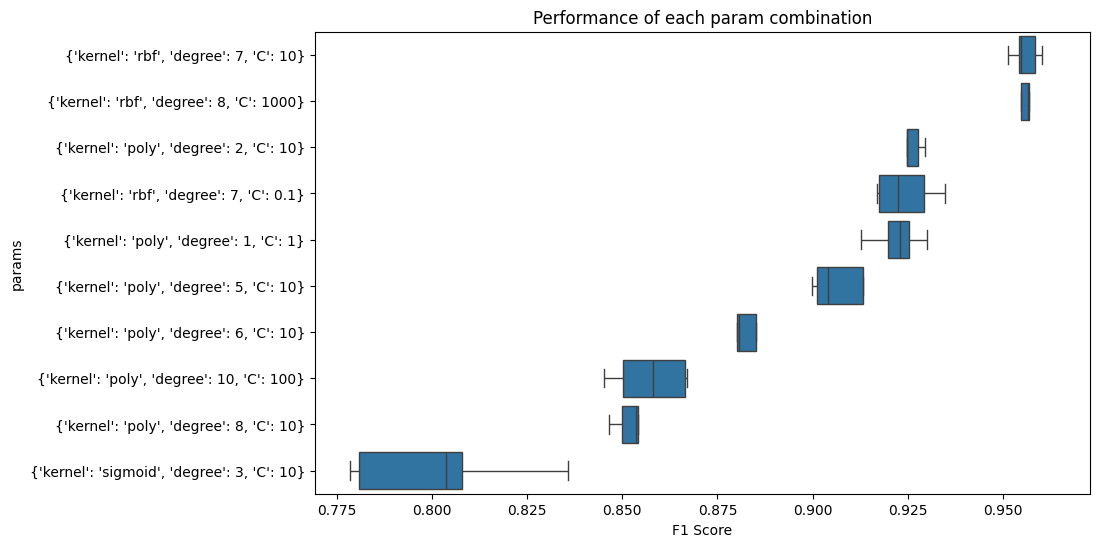

In [42]:
plot_cv_results(scv_search.cv_results_, "Performance of each param combination")

It seems like a `kernel="rbf"` with a `C=10` is the winner with an average `f1` score of : `0.96`. Let's train a model with these parameters and evaluate it.


In [46]:
from sklearn.model_selection import cross_validate

scoring = ["f1", "accuracy", "roc_auc"]

# Each model with the top parameters will be assigned the t_ prefix (for top)
t_svc = SVC(C=10, kernel="rbf")
t_svc_cv = cross_validate(t_svc, x_train_pca, y_train, scoring=scoring, cv=cv)
t_svc_cv

{'fit_time': array([0.1146841 , 0.11046672, 0.10855293, 0.10792804, 0.10043716]),
 'score_time': array([0.07210517, 0.07266092, 0.07130909, 0.06823874, 0.06430292]),
 'test_f1': array([0.95843521, 0.96032389, 0.95145631, 0.95469256, 0.95439739]),
 'test_accuracy': array([0.94585987, 0.94798301, 0.93630573, 0.94055202, 0.94055202]),
 'test_roc_auc': array([0.98573933, 0.98656582, 0.98138149, 0.98158686, 0.98551393])}